# Data exploration of data in timestream db

## Initialization

In [2]:
import awswrangler as wr
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

#%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(16,9)})
sns.set_theme(style="whitegrid", palette="colorblind")
sns.set_context("paper")
load_dotenv()


True

## Data retrieval

In [3]:
df = wr.timestream.query('SELECT * FROM "when-to-water"."sensor-data"')


### Transformations

In [4]:
df["time"] = pd.to_datetime(df["time"])
df_humidity = df[df["measure_name"] == "humidity"].rename(columns={"measure_value::double": "humidity in %"})
df_temperature = df[df["measure_name"] == "temperature"].rename(columns={"measure_value::double": "temperature in %"})

## Plots

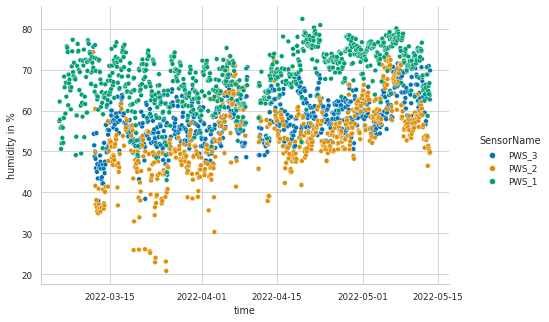

In [5]:
plot = sns.relplot(x="time", y="humidity in %", hue="SensorName", data=df_humidity, palette="colorblind")
plot.figure.set_size_inches(8, 4.5)
sns.despine()

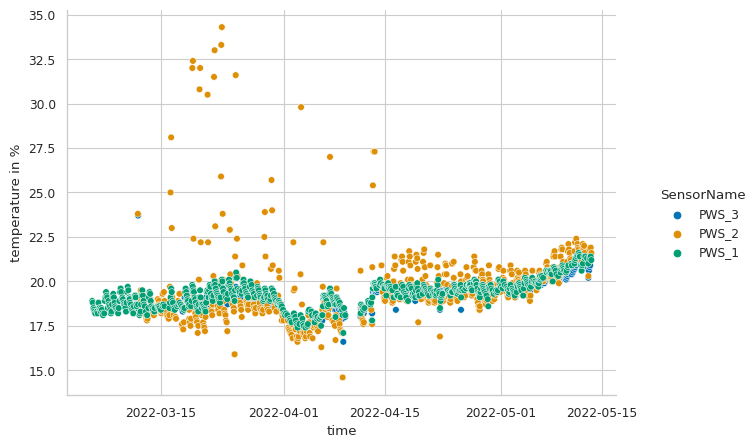

In [6]:
plot = sns.relplot(x="time", y="temperature in %", hue="SensorName", data=df_temperature, palette="colorblind")
plot.figure.set_size_inches(8, 4.5)
sns.despine()